# Imports semillas y utilidades

In [1]:
# imports principales
import os
import random
import math
from pathlib import Path
from dataclasses import dataclass
import json
import joblib  

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from ipywidgets import interact, IntSlider, FloatSlider, fixed
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

# reproducibilidad con semillas
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True       
set_seed(42)

# dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

# Configuración (rutas e hiperparámetros)

In [2]:
# configuración de entrenamiento con fine tuning
@dataclass
class TrainConfig:
    data_root: str = "."  
    img_size: int = 224
    batch_size: int = 32
    num_workers: int = 4
    base_lr: float = 3e-4
    weight_decay: float = 1e-4
    max_epochs: int = 5
    early_stop_patience: int = 3
    freeze_until: str = "features.denseblock4"
    use_mixed_precision: bool = True

# cfguración de entrenamiento
cfg = TrainConfig()
print(cfg)


TrainConfig(data_root='.', img_size=224, batch_size=32, num_workers=4, base_lr=0.0003, weight_decay=0.0001, max_epochs=5, early_stop_patience=3, freeze_until='features.denseblock4', use_mixed_precision=True)


# Transforms y DataLoaders (usa ImageFolder con la estructura dada)

In [3]:

# normalización imagenet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# transformaciones
train_tfms = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.10, contrast=0.10),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# transformaciones evaluación
eval_tfms = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# datasets
train_dir = Path(cfg.data_root) / "Train"
test_dir = Path(cfg.data_root) / "Test"

# bases de datos sin split
train_base = datasets.ImageFolder(train_dir) 
val_base = datasets.ImageFolder(train_dir) 
test_ds = datasets.ImageFolder(test_dir, transform=eval_tfms)

# split reproducible
val_ratio = 0.15
rng = np.random.default_rng(42)
all_idx = np.arange(len(train_base.samples))
rng.shuffle(all_idx)
num_val = int(len(all_idx) * val_ratio)
val_idx = all_idx[:num_val]
train_idx = all_idx[num_val:]

# subset con transformaciones
class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, base, indices, transform):
        self.base = base
        self.indices = list(indices)
        self.transform = transform
        self.samples = [base.samples[i] for i in self.indices]
        self.classes = base.classes
        self.class_to_idx = base.class_to_idx
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        path, y = self.samples[i]
        img = Image.open(path).convert("RGB")
        return self.transform(img), y

train_ds = SubsetWithTransform(train_base, train_idx, train_tfms)
val_ds   = SubsetWithTransform(val_base,   val_idx,   eval_tfms)

# calcula pos_weight para la loss 
targets_train = np.array([t for _, t in train_ds.samples])
pos = (targets_train == 1).sum()
neg = (targets_train == 0).sum()
pos_weight_value = max(1e-6, neg / max(1, pos))  

# dataloaders simples 
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False,
                          num_workers=0, pin_memory=False)
test_loader = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False,
                          num_workers=0, pin_memory=False)

print("train/val/test:", len(train_ds), len(val_ds), len(test_ds), "| pos_weight:", round(pos_weight_value, 3))


train/val/test: 4434 782 624 | pos_weight: 0.34


# Modelo (DenseNet121 preentrenado + fine-tuning parcial)

In [4]:
# carga densenet121 con pesos imagenet
def build_model(num_classes: int = 1):
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    in_feats = model.classifier.in_features
    model.classifier = nn.Linear(in_feats, num_classes)
    return model

model = build_model().to(device)

# congela capas hasta cierto bloque para fine-tuning parcial 
def freeze_backbone_until(model: nn.Module, module_name: str):
    # congela todo inicialmente
    for p in model.parameters():
        p.requires_grad = False
    # reactiva grad a partir del módulo indicado
    reached = False
    for name, module in model.named_modules():
        if name == module_name:
            reached = True
        if reached:
            for p in module.parameters(recurse=True):
                p.requires_grad = True
    # el clasificador siempre entrenable
    for p in model.classifier.parameters():
        p.requires_grad = True

freeze_backbone_until(model, cfg.freeze_until)

# pérdida y optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=cfg.base_lr, weight_decay=cfg.weight_decay
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=1, verbose=False
)

# amp
try:
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type == 'cuda' and cfg.use_mixed_precision))
except TypeError:
    # compatibilidad con versiones antiguas
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_mixed_precision)


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Utilidades de métrica y loops de entrenamiento

In [5]:
# convierte logits a probabilidades sigmoide
def logits_to_probs(logits: torch.Tensor) -> torch.Tensor:
    return torch.sigmoid(logits)

# evalúa en loader y devuelve dict con métricas
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader):
    model.eval()
    all_logits, all_targets = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.float().to(device, non_blocking=True).view(-1, 1)
        logits = model(x)
        all_logits.append(logits.detach().cpu())
        all_targets.append(y.detach().cpu())
    logits = torch.cat(all_logits, dim=0).numpy().ravel()
    targets = torch.cat(all_targets, dim=0).numpy().ravel()
    probs = 1.0 / (1.0 + np.exp(-logits))
    roc = roc_auc_score(targets, probs)
    pr  = average_precision_score(targets, probs)
    return {"roc_auc": float(roc), "pr_auc": float(pr)}, logits, targets

# entrena una época con amp moderno
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, scaler, criterion):
    model.train()
    running_loss = 0.0
    for x, y in tqdm(loader, leave=False):
        x = x.to(device, non_blocking=True)
        y = y.float().to(device, non_blocking=True).view(-1, 1)
        optimizer.zero_grad(set_to_none=True)
        try:
            ctx = torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda' and cfg.use_mixed_precision))
        except TypeError:
            ctx = torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision)
        with ctx:
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

# early stopping
def early_stopping_update(best_score, current_score, patience_counter, mode="max"):
    improved = (current_score > best_score) if mode == "max" else (current_score < best_score)
    if improved:
        return current_score, 0, True
    else:
        return best_score, patience_counter + 1, False


# Entrenamiento con early-stopping y guardar el mejor modelo

In [6]:
# mejor valor inicia en menos infinito para maximizar roc auc, contador de paciencia en 0
best_val = -np.inf
patience = 0
best_path = "chest_aid_densenet121.pth"

# bucle de épocas con early stopping
for epoch in range(1, cfg.max_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, scaler, criterion)
    val_metrics, _, _ = evaluate(model, val_loader)
    scheduler.step(val_metrics["roc_auc"])
    best_val, patience, improved = early_stopping_update(best_val, val_metrics["roc_auc"], patience, mode="max")
    if improved:
        torch.save(model.state_dict(), best_path)
    print(f"epoch {epoch:02d} | train_loss={train_loss:.4f} | val_roc_auc={val_metrics['roc_auc']:.4f} | val_pr_auc={val_metrics['pr_auc']:.4f} | patience={patience}")
    if patience >= cfg.early_stop_patience:
        print("early stopping activado")
        break

# carga el mejor
try:
    state = torch.load(best_path, map_location=device, weights_only=True) 
except TypeError:
    state = torch.load(best_path, map_location=device)
model.load_state_dict(state)
model.eval()


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 01 | train_loss=0.1314 | val_roc_auc=0.9956 | val_pr_auc=0.9983 | patience=0


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 02 | train_loss=0.0555 | val_roc_auc=0.9947 | val_pr_auc=0.9977 | patience=1


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 03 | train_loss=0.0391 | val_roc_auc=0.9953 | val_pr_auc=0.9979 | patience=2


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 04 | train_loss=0.0246 | val_roc_auc=0.9975 | val_pr_auc=0.9990 | patience=0


  0%|          | 0/139 [00:00<?, ?it/s]

epoch 05 | train_loss=0.0158 | val_roc_auc=0.9978 | val_pr_auc=0.9991 | patience=0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Calibración: Temperature Scaling (post-hoc) + Brier + ECE

In [7]:

# escalador de temperatura
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)
    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        t = self.temperature.clamp(0.05, 10.0)
        return logits / t

# métricas de calibración
@torch.no_grad()
def brier_score(probs: np.ndarray, targets: np.ndarray) -> float:
    return float(np.mean((probs - targets) ** 2))

# métrica ECE
@torch.no_grad()
def expected_calibration_error(probs: np.ndarray, targets: np.ndarray, n_bins: int = 15) -> float:
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (probs >= lo) & (probs < hi)
        if np.any(m):
            acc = np.mean(targets[m] == (probs[m] >= 0.5))
            conf = np.mean(probs[m])
            ece += np.abs(acc - conf) * (np.sum(m) / probs.size)
    return float(ece)

# fit de temperatura sobre logits
def fit_temperature_on_logits(logits_t: torch.Tensor, targets_t: torch.Tensor, max_iter: int = 200, lr: float = 0.01):
    scaler_t = TemperatureScaler().to(device)
    optimizer = torch.optim.LBFGS(scaler_t.parameters(), lr=lr, max_iter=max_iter)
    bce = nn.BCEWithLogitsLoss()

    def closure():
        optimizer.zero_grad()
        loss = bce(scaler_t(logits_t), targets_t)
        loss.backward()
        return loss

    optimizer.step(closure)
    return scaler_t


# separa validación en dos mitades val report / calib # 40% report  60% calib
# etiquetas de toda la validación original
val_labels_all = np.array([val_base.samples[i][1] for i in val_idx])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.60, random_state=42) 
val_report_rel, calib_rel = next(sss.split(val_idx, val_labels_all))
val_report_idx = np.array(val_idx)[val_report_rel]
calib_idx = np.array(val_idx)[calib_rel]

# datasets con eval_tfms sin augmentations
val_report_ds = SubsetWithTransform(val_base, val_report_idx, eval_tfms)
calib_ds = SubsetWithTransform(val_base, calib_idx,      eval_tfms)

# dataloaders
val_report_loader = DataLoader(val_report_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0, pin_memory=False)
calib_loader = DataLoader(calib_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0, pin_memory=False)

# evalúa pre-calibración en val_report y test
val_metrics,  val_report_logits, val_report_targets = evaluate(model, val_report_loader)
test_metrics, test_logits, test_targets  = evaluate(model, test_loader)

val_report_probs = 1 / (1 + np.exp(-val_report_logits))
test_probs = 1 / (1 + np.exp(-test_logits))

print(f"pre-calibración | val_report roc-auc: {val_metrics['roc_auc']:.4f} | pr-auc: {val_metrics['pr_auc']:.4f}")
print(f"pre-calibración | test roc-auc: {test_metrics['roc_auc']:.4f} | pr-auc: {test_metrics['pr_auc']:.4f}")
print(f"val_report brier (pre): {brier_score(val_report_probs, val_report_targets):.4f} | val_report ece (pre): {expected_calibration_error(val_report_probs, val_report_targets):.4f}")

# recolecta logits/targets del split de calibración para ajustar
_, calib_logits, calib_targets = evaluate(model, calib_loader)
calib_logits_torch = torch.from_numpy(calib_logits).float().view(-1, 1).to(device)
calib_targets_torch = torch.from_numpy(calib_targets).float().view(-1, 1).to(device)

# entrena calibradores
# temperature scaling
temp_scaler = fit_temperature_on_logits(calib_logits_torch, calib_targets_torch)
t_learned = float(temp_scaler.temperature.data.item())
val_probs_ts = 1 / (1 + np.exp(- (val_report_logits / t_learned)))
ece_val_ts = expected_calibration_error(val_probs_ts, val_report_targets)
brier_val_ts = brier_score(val_probs_ts, val_report_targets)
print(f"ts: temperatura={t_learned:.4f} | val_report brier post: {brier_val_ts:.4f} | val_report ece post: {ece_val_ts:.4f}")

#  platt scaling logistic regression sobre logits
platt = LogisticRegression(max_iter=2000)
platt.fit(calib_logits.reshape(-1, 1), calib_targets)
val_probs_platt = platt.predict_proba(val_report_logits.reshape(-1, 1))[:, 1]
ece_val_platt = expected_calibration_error(val_probs_platt, val_report_targets)
brier_val_platt = brier_score(val_probs_platt, val_report_targets)
print(f"platt: val_report brier: {brier_val_platt:.4f} | val_report ece: {ece_val_platt:.4f}")

# isotonic regression 
iso = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip")
iso.fit(calib_logits, calib_targets)
val_probs_iso = iso.predict(val_report_logits)
ece_val_iso = expected_calibration_error(val_probs_iso, val_report_targets)
brier_val_iso = brier_score(val_probs_iso, val_report_targets)
print(f"iso: val_report brier: {brier_val_iso:.4f} | val_report ece: {ece_val_iso:.4f}")

# elige mejor calibrador y aplícalo a test
candidates = {
    "ts": (ece_val_ts, brier_val_ts, lambda x: 1 / (1 + np.exp(- (x / t_learned)))),
    "platt": (ece_val_platt, brier_val_platt, lambda x: platt.predict_proba(x.reshape(-1,1))[:,1]),
    "iso":(ece_val_iso, brier_val_iso, lambda x: iso.predict(x)),
}
best_name = min(candidates, key=lambda k: candidates[k][0])
best_ece, best_brier, best_fn = candidates[best_name]
print(f"mejor calibrador (según val_report): {best_name} | ece={best_ece:.4f} | brier={best_brier:.4f}")

# aplica calibrador ganador a test
test_probs_cal = best_fn(test_logits)

# metricas finales en test (pre/post)
print(f"brier test (pre): {brier_score(test_probs, test_targets):.4f} | brier test (post): {brier_score(test_probs_cal, test_targets):.4f}")
print(f"ece test (pre): {expected_calibration_error(test_probs, test_targets):.4f} | ece test (post): {expected_calibration_error(test_probs_cal, test_targets):.4f}")


pre-calibración | val_report roc-auc: 0.9984 | pr-auc: 0.9994
pre-calibración | test roc-auc: 0.9605 | pr-auc: 0.9650
val_report brier (pre): 0.0067 | val_report ece (pre): 0.2723
ts: temperatura=1.1710 | val_report brier post: 0.0073 | val_report ece post: 0.2705
platt: val_report brier: 0.0075 | val_report ece: 0.2718
iso: val_report brier: 0.0087 | val_report ece: 0.2733
mejor calibrador (según val_report): ts | ece=0.2705 | brier=0.0073
brier test (pre): 0.1469 | brier test (post): 0.1432
ece test (pre): 0.3384 | ece test (post): 0.3325


# Curvas ROC/PR y umbrales clínicos

In [8]:
# busca umbral con sensibilidad objetivo y mejor especificidad
def find_threshold_for_sensitivity(targets: np.ndarray, probs: np.ndarray, target_sens: float = 0.90):
    fpr, tpr, thr = roc_curve(targets, probs)
    # crea mascara de puntos con sensibilidad al menos target_sens
    mask = tpr >= target_sens
    if not np.any(mask):
        # si no alcanza, elige el de mayor tpr
        idx = np.argmax(tpr)
    else:
        # dentro de los que cumplen sensibilidad, maximiza especificidad
        idx = np.argmax(1 - fpr[mask])
        idx = np.arange(len(tpr))[mask][idx]
    return float(thr[idx]), float(tpr[idx]), float(1 - fpr[idx])

# evalua metricas en un umbral 
def evaluate_at_threshold(targets: np.ndarray, probs: np.ndarray, thr: float):
    preds = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
    sens = tp / (tp + fn + 1e-8)
    spec = tn / (tn + fp + 1e-8)
    return {"threshold": thr, "sensitivity": float(sens), "specificity": float(spec),
            "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn)}

# encuentra umbral clinico con sensibilidad objetivo
thr90, sens90, spec90 = find_threshold_for_sensitivity(test_targets, test_probs_cal, target_sens=0.90)
metrics_thr = evaluate_at_threshold(test_targets, test_probs_cal, thr90)
metrics_thr


{'threshold': 0.9964610934257507,
 'sensitivity': 0.899999999976923,
 'specificity': 0.9059829059441887,
 'tp': 351,
 'fp': 22,
 'tn': 212,
 'fn': 39}

# Grad-CAM (automático sobre la última conv del backbone)

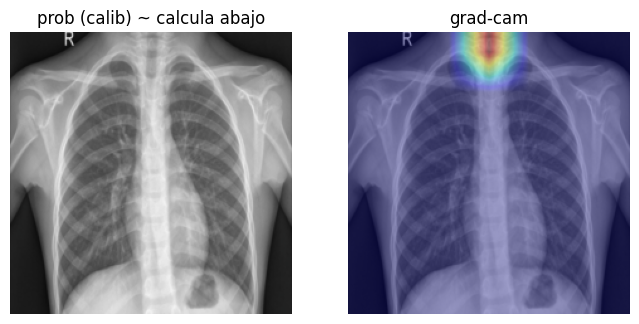

In [9]:
# busca la ultima capa conv2d dentro de features
def get_last_conv_layer(module: nn.Module):
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    return last

# grad cam con hooks en la capa objetivo
class GradCAM:
    def __init__(self, model: nn.Module, target_module: nn.Module):
        self.model = model
        self.target_module = target_module
        self.activations = None
        self.gradients = None
        # hooks
        self.fwd_hook = target_module.register_forward_hook(self._save_activation)
        self.bwd_hook = target_module.register_full_backward_hook(self._save_gradient)

    # almacena las activaciones del forward
    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    # almacena los gradientes del backward
    def _save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    # genera el mapa grad cam para la clase objetivo
    def generate(self, x: torch.Tensor, class_idx: int = 0):
        # forward + backward para obtener gradientes de la clase positiva 
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)  # [b,1]
        score = logits[:, class_idx].sum()
        score.backward(retain_graph=True)
        # pesos promedio espacial de gradientes
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        # normaliza a [0,1]
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam 

    def close(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

# inicializa grad-cam
target_conv = get_last_conv_layer(model.features)
cam_engine = GradCAM(model, target_conv)

# superpone el grad cam sobre la imagen original
def overlay_cam_on_image(img_tensor: torch.Tensor, cam: torch.Tensor, alpha: float = 0.35):
    # prepara tensores de media y desviacion de imagenet
    mean = torch.tensor(imagenet_mean).view(3,1,1)
    std  = torch.tensor(imagenet_std).view(3,1,1)
    img = img_tensor.cpu() * std + mean
    img = img.clamp(0,1).permute(1,2,0).numpy()

    heat = cam.squeeze().cpu().numpy()
    heat = (heat * 255).astype(np.uint8)
    heat = Image.fromarray(heat).resize((img.shape[1], img.shape[0]), resample=Image.BILINEAR)
    heat = np.array(heat) / 255.0

    # usa colormap jet
    cmap = plt.get_cmap('jet')
    heat_color = cmap(heat)[...,:3]
    overlay = (1 - alpha) * img + alpha * heat_color
    overlay = overlay.clip(0,1)
    return img, overlay

# toma un batch de prueba para ejemplo rapido
batch = next(iter(test_loader))
x_batch, y_batch = batch
x0 = x_batch[0:1].to(device)
with torch.no_grad():
    logits0 = model(x0)
    prob0 = torch.sigmoid(logits0).item()

cam0 = cam_engine.generate(x0, class_idx=0)
orig_img, overlay = overlay_cam_on_image(x_batch[0], cam0[0])

# muestra lado a lado imagen original y grad cam
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.title(f"prob (calib) ~ calcula abajo"); plt.imshow(orig_img); plt.axis('off')
plt.subplot(1,2,2); plt.title("grad-cam"); plt.imshow(overlay); plt.axis('off')
plt.show()


# Selección de TP/FP/FN/TN y panel de ejemplos

tn=212 fp=22 fn=39 tp=351


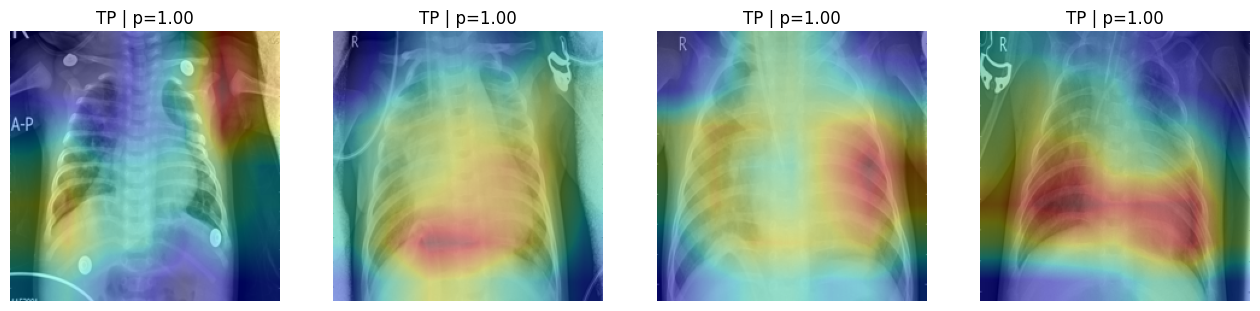

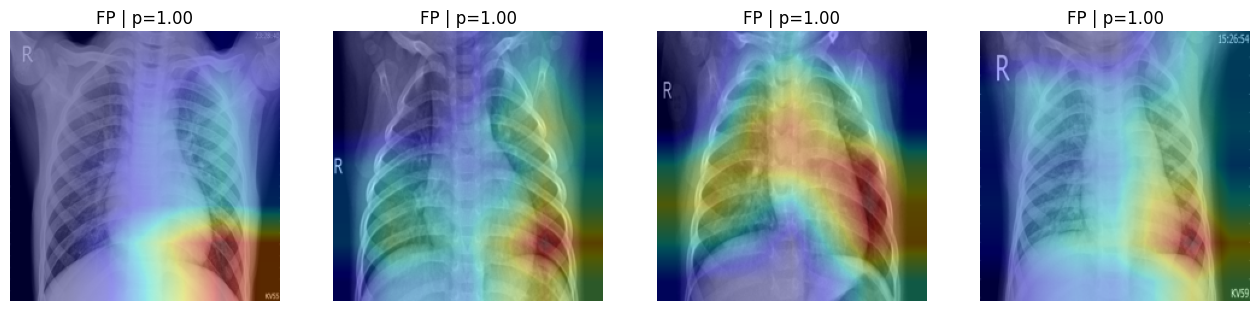

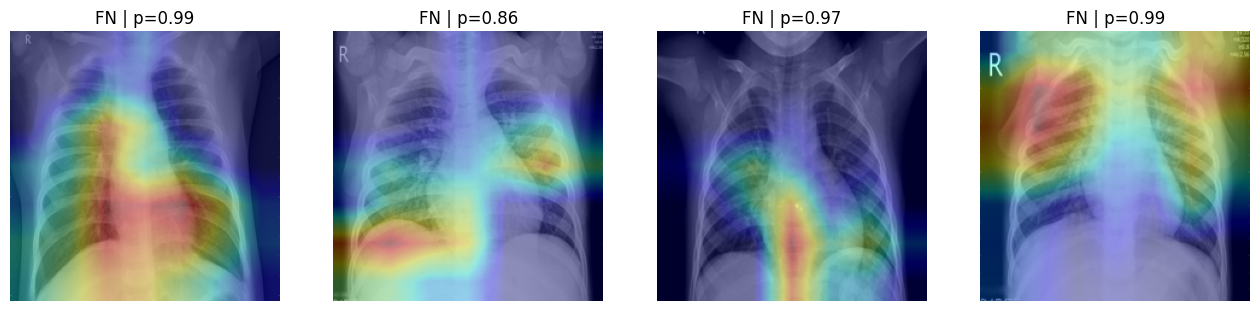

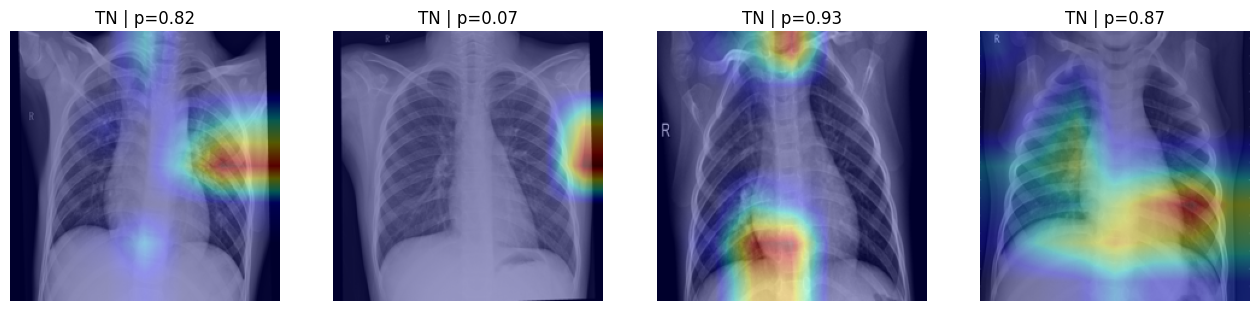

In [10]:
# evita gradientes al recolectar predicciones
@torch.no_grad()
def collect_predictions(model, loader, t_scaler=None):
    model.eval()
    all_probs, all_targets, all_paths = [], [], []
    for (x, y), paths in zip(loader, getattr(loader.dataset, 'samples', [None]*len(loader))):
        x = x.to(device)
        logits = model(x)
        if t_scaler is not None:
            t = max(0.05, min(10.0, t_scaler.temperature.data.item()))
            logits = logits / t
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        all_probs.extend(probs.tolist())
        all_targets.extend(y.numpy().ravel().tolist())
        if isinstance(paths, tuple):
            all_paths.extend([p for (_, p) in loader.dataset.samples[:len(x)]])
    return np.array(all_probs), np.array(all_targets)

# usa las probabilidades calibradas de prueba
test_probs_final = test_probs_cal
thr_use = metrics_thr["threshold"]

# clasifica en tp/fp/fn/tn
preds_final = (test_probs_final >= thr_use).astype(int)
tn, fp, fn, tp = confusion_matrix(test_targets, preds_final).ravel()
print(f"tn={tn} fp={fp} fn={fn} tp={tp}")

# función para visualizar n ejemplos por categoría
def show_examples_by_type(loader, probs, targets, preds, target_type="TP", n=4):
    # selecciona índices según tipo
    if target_type.upper() == "TP":
        idx = np.where((targets == 1) & (preds == 1))[0]
    elif target_type.upper() == "FP":
        idx = np.where((targets == 0) & (preds == 1))[0]
    elif target_type.upper() == "FN":
        idx = np.where((targets == 1) & (preds == 0))[0]
    else:
        idx = np.where((targets == 0) & (preds == 0))[0]
    if len(idx) == 0:
        print("no hay ejemplos para este tipo")
        return
    idx = np.random.choice(idx, size=min(n, len(idx)), replace=False)

    # mapea índice global al archivo en ImageFolder
    files = [loader.dataset.samples[i][0] for i in idx]
    fig, axs = plt.subplots(1, len(idx), figsize=(4*len(idx), 4))
    if len(idx) == 1:
        axs = [axs]
    for ax, i, f in zip(axs, idx, files):
        img = Image.open(f).convert("RGB").resize((cfg.img_size, cfg.img_size))
        img_t = eval_tfms(img).unsqueeze(0).to(device)
        cam = cam_engine.generate(img_t, class_idx=0)
        _, over = overlay_cam_on_image(eval_tfms(img), cam[0])
        ax.imshow(over)
        ax.set_title(f"{target_type} | p={probs[i]:.2f}")
        ax.axis('off')
    plt.show()

# muestra verdaderos positivos, falsos positivos, falsos negativos y verdaderos negativos
show_examples_by_type(test_loader, test_probs_final, test_targets, preds_final, "TP", n=4)
show_examples_by_type(test_loader, test_probs_final, test_targets, preds_final, "FP", n=4)
show_examples_by_type(test_loader, test_probs_final, test_targets, preds_final, "FN", n=4)
show_examples_by_type(test_loader, test_probs_final, test_targets, preds_final, "TN", n=4)


# Demo interactiva (imagen del test + umbral deslizable + grad-cam)

In [ ]:
# prepara una lista de paths del split de test
test_paths = [p for (p, lbl) in test_ds.samples]
test_labels = [lbl for (p, lbl) in test_ds.samples]

# demo interactivo para ver prediccion y grad cam por indice
def demo_view(idx: int = 0, threshold: float = 0.5):
    # carga imagen, predice con temperatura y muestra grad-cam
    idx = max(0, min(idx, len(test_paths)-1))
    img_path = test_paths[idx]
    true_lbl = test_labels[idx]
    img = Image.open(img_path).convert("RGB").resize((cfg.img_size, cfg.img_size))
    x = eval_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        t = max(0.05, min(10.0, temp_scaler.temperature.data.item()))
        logits = logits / t
        prob = torch.sigmoid(logits).item()

    # genera mapa grad cam para la clase positiva
    cam = cam_engine.generate(x, class_idx=0)
    orig, over = overlay_cam_on_image(eval_tfms(img), cam[0])

    pred_lbl = int(prob >= threshold)

    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1); plt.imshow(orig); plt.axis('off'); plt.title(f"true={'PNEU' if true_lbl==1 else 'NORM'} | prob_cal={prob:.3f} | thr={threshold:.2f} | pred={'PNEU' if pred_lbl==1 else 'NORM'}")
    plt.subplot(1,2,2); plt.imshow(over); plt.axis('off'); plt.title("grad-cam")
    plt.show()

# crea controles interactivos para indice y umbral
interact(
    demo_view,
    idx=IntSlider(min=0, max=len(test_paths)-1, step=1, value=0, description='idx'),
    threshold=FloatSlider(min=0.0, max=1.0, step=0.01, value=metrics_thr["threshold"], description='threshold')
)

interactive(children=(IntSlider(value=0, description='idx', max=623), FloatSlider(value=0.9964610934257507, de…

<function __main__.demo_view(idx: int = 0, threshold: float = 0.5)>

# Guardar artefactos y cómo cargar para inferencia

In [12]:
import json
import joblib  # para guardar modelos sklearn

# guarda pesos del modelo
torch.save(model.state_dict(), "chest_aid_densenet121.pth")

# guarda calibrador
calib_meta = {"type": best_name}
if best_name == "ts":
    torch.save(temp_scaler.state_dict(), "temperature_scaler.pth")
elif best_name == "platt":
    joblib.dump(platt, "calibrator_platt.joblib")
elif best_name == "iso":
    joblib.dump(iso, "calibrator_iso.joblib")
with open("calibrator_meta.json", "w") as f:
    json.dump(calib_meta, f)

# funcion de inferencia por archivo (aplica calibrador ganador)
def predict_image(path: str):
    # realiza inferencia en una sola imagen con calibración y grad-cam
    img = Image.open(path).convert("RGB").resize((cfg.img_size, cfg.img_size))
    x = eval_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x).detach().cpu().numpy().ravel()
    # aplica calibración
    with open("calibrator_meta.json", "r") as f:
        meta = json.load(f)
    ctype = meta["type"]
    if ctype == "ts" and Path("temperature_scaler.pth").exists():
        ts = TemperatureScaler().to(device)
        ts.load_state_dict(torch.load("temperature_scaler.pth", map_mode='cpu') if hasattr(torch.load, '__call__') else torch.load("temperature_scaler.pth", map_location='cpu'))
        t_val = float(ts.temperature.data.cpu().item())
        probs = 1 / (1 + np.exp(- (logits / t_val)))
    elif ctype == "platt" and Path("calibrator_platt.joblib").exists():
        pl = joblib.load("calibrator_platt.joblib")
        probs = pl.predict_proba(logits.reshape(-1,1))[:,1]
    elif ctype == "iso" and Path("calibrator_iso.joblib").exists():
        isocal = joblib.load("calibrator_iso.joblib")
        probs = isocal.predict(logits)
    else:
        # fallback sin calibración
        probs = 1 / (1 + np.exp(-logits))
    prob = float(probs[0])

    # grad-cam
    x_gpu = x.to(device)
    cam_map = GradCAM(model, get_last_conv_layer(model.features)).generate(x_gpu, class_idx=0)
    _, over = overlay_cam_on_image(x.squeeze(0), cam_map[0])

    # devuelve probabilidad, imagen original desnormalizada y overlay
    orig = ( (x.squeeze(0).cpu() * torch.tensor(imagenet_std).view(3,1,1) + torch.tensor(imagenet_mean).view(3,1,1)).clamp(0,1).permute(1,2,0).numpy() * 255 ).astype(np.uint8)
    return prob, orig, over
